# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_069  P24593                            17.443
Sample_189  P05997                            14.694
Sample_047  P06733                            15.467
Sample_051  C9JIZ6;P07602;P07602-2;P07602-3   20.381
Sample_068  P61769                            24.595
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups      
Sample_108  E9PK25;G3V1A4;P23528   14.888
Sample_053  P18206;P18206-2        14.288
Sample_119  F5GWQ8;J3QKW8;Q15846   14.897
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.556
            A0A075B6Q5                 13.226
            A0A075B6R2                 12.341
            A0A075B6S5                 13.348
            A0A087WSY4                 12.559
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.546
            Q9UI40;Q9UI40-2            12.266
            Q9UIW2                     13.590
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.519
            Q9UP79                     12.891
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.300,15.050,16.842,19.863,15.733,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.681,19.067,...,15.528,15.576,13.960,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.755,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.077,17.705,17.039,15.981,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.943,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.529,15.345,17.084,18.708,14.249,19.433,12.252,11.310
Sample_207,15.739,16.877,15.469,16.898,15.012,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.556,...,16.012,15.178,12.307,15.050,16.842,19.863,13.936,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.876,19.067,16.188,...,15.528,15.576,13.034,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.500,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.523,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.430,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.269,15.345,17.084,18.708,14.249,19.433,13.809,13.436
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 352.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]

100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.11it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.15it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.69it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.98it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.33it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  2.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.76it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.61it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.26it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.21it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.26it/s]

100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.35it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.59it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.72it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.90it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.97it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.10it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.64it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.91it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.70it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.97it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.10it/s]

100%|██████████| 9/9 [00:03<00:00,  1.82it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.53it/s]

 30%|███       | 3/10 [00:00<00:02,  2.70it/s]

 40%|████      | 4/10 [00:01<00:03,  1.94it/s]

 50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.59it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.80it/s]

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.21it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.54it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.41it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.32it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.59it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.81it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.88it/s]

100%|██████████| 11/11 [00:04<00:00,  2.98it/s]

100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.33it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.05it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.73it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.43it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.77it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.52it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.37it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.37it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.46it/s]

100%|██████████| 12/12 [00:04<00:00,  2.15it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.63it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.00it/s]

 31%|███       | 4/13 [00:01<00:02,  3.04it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.90it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.88it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.77it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.38it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.05it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.89it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.79it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.75it/s]

100%|██████████| 13/13 [00:05<00:00,  1.74it/s]

100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.05it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.01it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.34it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.92it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.82it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.77it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.72it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.93it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.11it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.09it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.13it/s]

100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.90it/s]

 20%|██        | 3/15 [00:01<00:05,  2.01it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.76it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.76it/s]

 40%|████      | 6/15 [00:03<00:05,  1.77it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.90it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.20it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.27it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.34it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.33it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.27it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.43it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.48it/s]

100%|██████████| 15/15 [00:06<00:00,  2.21it/s]

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.064 0.026          0.724 0.383       0.100   
2             0.005 0.005      0.071 0.030          0.723 0.100       0.557   
3             0.006 0.004      0.085 0.036          0.772 0.109       0.711   
4             0.004 0.002      0.061 0.025          0.767 0.098       0.730   
5             0.006 0.007      0.081 0.037          0.813 0.090       0.744   
6             0.005 0.003      0.087 0.037          0.817 0.093       0.774   
7             0.004 0.001      0.054 0.016          0.817 0.094       0.779   
8             0.007 0.006      0.092 0.045          0.812 0.093       0.782   
9             0.006 0.007      0.076 0.042          0.822 0.088       0.845   
10            0.004 0.002      0.055 0.018          0.820 0.086       0.835   
11            0.008 0.008      0.100 0.034          0.825 0.079       0.821   
12            0.011 0.009      0.089 0.039          0.822 0.079       0.822   
13            0.007 0.008      0.074 0.027          0.815 0.080       0.811   
14            0.008 0.007      0.070 0.027          0.810 0.083       0.805   
15            0.006 0.007      0.065 0.032          0.809 0.079       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.169 0.122                  0.543 0.038        0.861   
2          0.116   0.622 0.091                  0.698 0.063        0.798   
3          0.118   0.733 0.086                  0.775 0.069        0.873   
4          0.119   0.742 0.084                  0.781 0.067        0.883   
5          0.100   0.772 0.074                  0.807 0.061        0.902   
6          0.092   0.791 0.072                  0.822 0.060        0.910   
7          0.090   0.793 0.072                  0.823 0.060        0.908   
8          0.096   0.792 0.073                  0.823 0.062        0.908   
9          0.099   0.828 0.069                  0.853 0.061        0.921   
10         0.100   0.823 0.070                  0.849 0.061        0.919   
11         0.101   0.819 0.069                  0.846 0.059        0.922   
12         0.099   0.818 0.068                  0.845 0.059        0.920   
13         0.095   0.809 0.068                  0.837 0.059        0.919   
14         0.092   0.804 0.067                  0.832 0.058        0.918   
15         0.096   0.804 0.067                  0.833 0.058        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.073                  0.722 0.092        210.000 0.000  
3          0.061                  0.837 0.081        210.000 0.000  
4          0.055                  0.850 0.072        210.000 0.000  
5          0.048                  0.882 0.057        210.000 0.000  
6          0.049                  0.891 0.058        210.000 0.000  
7          0.051                  0.888 0.060        210.000 0.000  
8          0.051                  0.889 0.060        210.000 0.000  
9          0.046                  0.905 0.051        210.000 0.000  
10         0.047                  0.901 0.054        210.000 0.000  
11         0.046                  0.905 0.053        210.000 0.000  
12         0.046                  0.904 0.053        210.000 0.000  
13         0.047                  0.901 0.055        210.000 0.000  
14         0.046                  0.900 0.053        210.000 0.000  
15         0.047                  0.900 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 478.58it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.97it/s]

100%|██████████| 3/3 [00:00<00:00,  2.96it/s]

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.89it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.58it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.18it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.84it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.38it/s]

100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.57it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.05it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.16it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.84it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.56it/s]

100%|██████████| 7/7 [00:03<00:00,  1.54it/s]

100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.68it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.76it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.57it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.56it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.50it/s]

100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

100%|██████████| 8/8 [00:03<00:00,  2.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.93it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.45it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.52it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.58it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.63it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.63it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.60it/s]

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

 40%|████      | 4/10 [00:01<00:02,  2.87it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.80it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.77it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.58it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:03<00:00,  2.40it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.10it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.66it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.28it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.09it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.02it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.46it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.45it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.49it/s]

100%|██████████| 11/11 [00:03<00:00,  2.61it/s]

100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.54it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.81it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.40it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.17it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.84it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.57it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.52it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.31it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.39it/s]

100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.60it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.96it/s]

 31%|███       | 4/13 [00:01<00:02,  3.50it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.12it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.39it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.20it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.22it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.33it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.42it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.65it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.84it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.55it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.25it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.33it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.43it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.49it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.50it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.58it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.75it/s]

100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.64it/s]

 20%|██        | 3/15 [00:01<00:04,  2.73it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.41it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.41it/s]

 40%|████      | 6/15 [00:02<00:03,  2.44it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.49it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.63it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.69it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.70it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.74it/s]

100%|██████████| 15/15 [00:05<00:00,  2.77it/s]

100%|██████████| 15/15 [00:05<00:00,  2.67it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.072 0.031          0.000 0.000       0.000   
2             0.006 0.005      0.077 0.035          0.845 0.086       0.657   
3             0.005 0.004      0.075 0.037          0.818 0.075       0.704   
4             0.006 0.005      0.086 0.040          0.795 0.076       0.731   
5             0.006 0.006      0.064 0.027          0.782 0.085       0.724   
6             0.006 0.006      0.077 0.040          0.778 0.087       0.718   
7             0.006 0.005      0.071 0.032          0.793 0.080       0.722   
8             0.005 0.004      0.059 0.024          0.796 0.089       0.781   
9             0.004 0.002      0.054 0.018          0.792 0.094       0.764   
10            0.004 0.002      0.052 0.018          0.816 0.088       0.777   
11            0.005 0.003      0.056 0.019          0.829 0.090       0.795   
12            0.004 0.002      0.053 0.017          0.822 0.095       0.780   
13            0.006 0.006      0.058 0.022          0.821 0.095       0.781   
14            0.005 0.003      0.057 0.020          0.820 0.088       0.772   
15            0.007 0.006      0.089 0.038          0.825 0.090       0.773   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.106   0.733 0.079                  0.783 0.056        0.871   
3          0.119   0.750 0.079                  0.794 0.059        0.873   
4          0.118   0.756 0.078                  0.796 0.061        0.885   
5          0.112   0.746 0.077                  0.787 0.061        0.887   
6          0.111   0.742 0.079                  0.783 0.063        0.884   
7          0.123   0.750 0.083                  0.791 0.064        0.887   
8          0.114   0.783 0.082                  0.816 0.068        0.901   
9          0.117   0.772 0.084                  0.807 0.069        0.900   
10         0.107   0.791 0.077                  0.823 0.063        0.914   
11         0.110   0.807 0.082                  0.836 0.068        0.917   
12         0.114   0.796 0.086                  0.827 0.072        0.916   
13         0.107   0.796 0.083                  0.827 0.070        0.915   
14         0.095   0.791 0.074                  0.823 0.062        0.915   
15         0.108   0.794 0.082                  0.826 0.066        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.088        210.000 0.000  
2          0.056                  0.837 0.077        210.000 0.000  
3          0.058                  0.843 0.076        210.000 0.000  
4          0.049                  0.863 0.058        210.000 0.000  
5          0.048                  0.860 0.060        210.000 0.000  
6          0.048                  0.857 0.059        210.000 0.000  
7          0.047                  0.861 0.059        210.000 0.000  
8          0.047                  0.877 0.059        210.000 0.000  
9          0.050                  0.877 0.060        210.000 0.000  
10         0.046                  0.898 0.054        210.000 0.000  
11         0.045                  0.899 0.053        210.000 0.000  
12         0.045                  0.899 0.054        210.000 0.000  
13         0.045                  0.897 0.054        210.000 0.000  
14         0.045                  0.897 0.052        210.000 0.000  
15         0.044                  0.902 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 993.68it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.32it/s]

100%|██████████| 2/2 [00:00<00:00, 18.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.05it/s]

100%|██████████| 3/3 [00:00<00:00, 11.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.09it/s]

100%|██████████| 4/4 [00:00<00:00, 15.49it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.08it/s]

100%|██████████| 5/5 [00:00<00:00, 14.96it/s]

100%|██████████| 5/5 [00:00<00:00, 15.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 29.13it/s]

100%|██████████| 6/6 [00:00<00:00, 26.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.65it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.35it/s]

100%|██████████| 7/7 [00:00<00:00, 18.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.25it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.60it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.40it/s]

100%|██████████| 8/8 [00:00<00:00, 14.04it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.32it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.96it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.16it/s]

100%|██████████| 9/9 [00:00<00:00, 12.54it/s]

100%|██████████| 9/9 [00:00<00:00, 13.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.33it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.06it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.50it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.75it/s]

100%|██████████| 10/10 [00:00<00:00, 14.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.33it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.19it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.61it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.82it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.29it/s]

100%|██████████| 11/11 [00:01<00:00, 10.52it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.80it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.67it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.06it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.38it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.61it/s]

100%|██████████| 12/12 [00:00<00:00, 13.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.93it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.63it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.88it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.36it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.18it/s]

100%|██████████| 13/13 [00:01<00:00, 11.43it/s]

100%|██████████| 13/13 [00:01<00:00, 11.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.32it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.22it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.23it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.25it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.64it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.28it/s]

100%|██████████| 14/14 [00:01<00:00, 11.91it/s]

100%|██████████| 14/14 [00:01<00:00, 12.15it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.84it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.74it/s]

 47%|████▋     | 7/15 [00:00<00:00, 10.62it/s]

 60%|██████    | 9/15 [00:00<00:00, 10.23it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.55it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.22it/s]

100%|██████████| 15/15 [00:01<00:00, 10.96it/s]

100%|██████████| 15/15 [00:01<00:00, 10.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.080 0.035          0.000 0.000       0.000   
2             0.007 0.006      0.088 0.041          0.667 0.108       0.532   
3             0.006 0.005      0.073 0.029          0.664 0.119       0.526   
4             0.004 0.003      0.049 0.009          0.611 0.113       0.510   
5             0.003 0.001      0.038 0.010          0.608 0.112       0.506   
6             0.002 0.000      0.028 0.003          0.667 0.083       0.587   
7             0.004 0.000      0.044 0.002          0.685 0.095       0.614   
8             0.003 0.001      0.039 0.007          0.670 0.103       0.613   
9             0.004 0.000      0.043 0.003          0.690 0.096       0.616   
10            0.006 0.005      0.066 0.026          0.689 0.101       0.617   
11            0.005 0.004      0.060 0.022          0.679 0.100       0.606   
12            0.004 0.002      0.053 0.015          0.686 0.100       0.620   
13            0.004 0.002      0.055 0.020          0.678 0.105       0.612   
14            0.004 0.000      0.047 0.004          0.671 0.099       0.605   
15            0.004 0.002      0.051 0.014          0.670 0.100       0.607   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.728   
2          0.104   0.584 0.082                  0.666 0.056        0.709   
3          0.109   0.579 0.093                  0.663 0.064        0.705   
4          0.110   0.549 0.093                  0.634 0.067        0.707   
5          0.106   0.546 0.091                  0.631 0.066        0.704   
6          0.106   0.618 0.076                  0.684 0.057        0.765   
7          0.116   0.642 0.090                  0.703 0.068        0.789   
8          0.121   0.634 0.093                  0.694 0.071        0.784   
9          0.125   0.644 0.095                  0.706 0.070        0.787   
10         0.124   0.644 0.093                  0.705 0.069        0.782   
11         0.113   0.634 0.085                  0.696 0.064        0.777   
12         0.131   0.642 0.095                  0.704 0.069        0.782   
13         0.137   0.634 0.102                  0.698 0.072        0.779   
14         0.126   0.628 0.092                  0.692 0.067        0.774   
15         0.123   0.630 0.092                  0.693 0.068        0.774   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.696 0.074        210.000 0.000  
2          0.067                  0.665 0.086        210.000 0.000  
3          0.068                  0.660 0.085        210.000 0.000  
4          0.066                  0.658 0.082        210.000 0.000  
5          0.066                  0.656 0.084        210.000 0.000  
6          0.058                  0.720 0.073        210.000 0.000  
7          0.068                  0.744 0.085        210.000 0.000  
8          0.070                  0.744 0.084        210.000 0.000  
9          0.066                  0.753 0.077        210.000 0.000  
10         0.065                  0.745 0.076        210.000 0.000  
11         0.067                  0.739 0.079        210.000 0.000  
12         0.070                  0.742 0.083        210.000 0.000  
13         0.071                  0.740 0.083        210.000 0.000  
14         0.071                  0.733 0.084        210.000 0.000  
15         0.071                  0.734 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,15,2
score_time,11,15,2
test_precision,11,2,9
test_recall,9,11,12
test_f1,9,11,9
test_balanced_accuracy,9,11,9
test_roc_auc,11,15,7
test_average_precision,11,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.70it/s]

 20%|██        | 3/15 [00:00<00:03,  3.17it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.96it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.64it/s]

 40%|████      | 6/15 [00:02<00:03,  2.68it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.65it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.70it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.45it/s]

100%|██████████| 15/15 [00:05<00:00,  2.18it/s]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.61it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.52it/s]

100%|██████████| 7/7 [00:00<00:00, 13.72it/s]

100%|██████████| 7/7 [00:00<00:00, 14.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.01it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.55it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.67it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.48it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.27it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.24it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.21it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.07it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.11it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


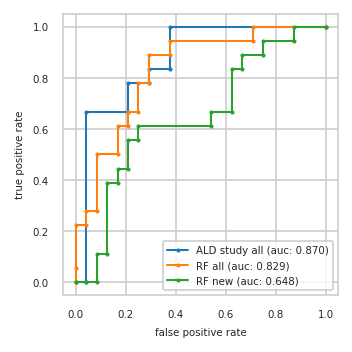

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.042 0.000
2          0.042 0.667  0.000 0.222  0.083 0.000
3          0.208 0.667  0.042 0.222  0.083 0.111
4          0.208 0.778  0.042 0.278  0.125 0.111
5          0.292 0.778  0.083 0.278  0.125 0.389
6          0.292 0.833  0.083 0.500  0.167 0.389
7          0.375 0.833  0.167 0.500  0.167 0.444
8          0.375 1.000  0.167 0.611  0.208 0.444
9          1.000 1.000  0.208 0.611  0.208 0.556
10           NaN   NaN  0.208 0.667  0.250 0.556
11           NaN   NaN  0.250 0.667  0.250 0.611
12           NaN   NaN  0.250 0.778  0.542 0.611
13           NaN   NaN  0.292 0.778  0.542 0.667
14           NaN   NaN  0.292 0.889  0.625 0.667
15           NaN   NaN  0.375 0.889  0.625 0.833
16           NaN   NaN  0.375 0.944  0.667 0.833
17           NaN   NaN  0.708 0.944  0.667 0.889
18           NaN   NaN  0.708 1.000  0.750 0.889
19           NaN   NaN  1.000 1.000  0.750 0.944
20           NaN   NaN    NaN   NaN  0.875 0.944
21           NaN   NaN    NaN   NaN  0.875 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,G3V4U0;G3XA98;Q9UBX5,P09382,P01704
2,A0A0B4J1V0,C9JIZ6;P07602;P07602-2;P07602-3,Q96GD0
3,P61981,P10636-2;P10636-6,P51688
4,Q99983,F8WE04;P04792,Q504Y2
5,P04075,P04075,P31321
6,P14174,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,None
8,P08294,P25189;P25189-2,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


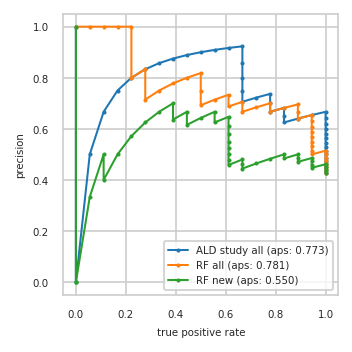

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.500 0.944     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.667 1.000     0.630 0.944     0.444 0.667
16         0.654 0.944     0.654 0.944     0.462 0.667
17         0.640 0.889     0.640 0.889     0.480 0.667
18         0.625 0.833     0.667 0.889     0.458 0.611
19         0.652 0.833     0.696 0.889     0.478 0.611
20         0.682 0.833     0.682 0.833     0.500 0.611
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.647 0.611
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.923 0.667     0.692 0.500     0.615 0.444
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.800 0.444     0.700 0.389
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.714 0.278     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


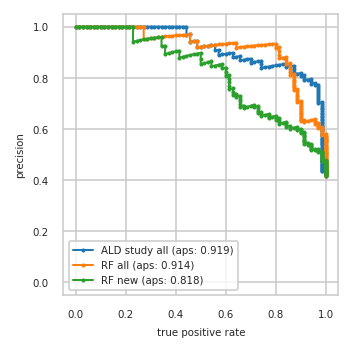

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


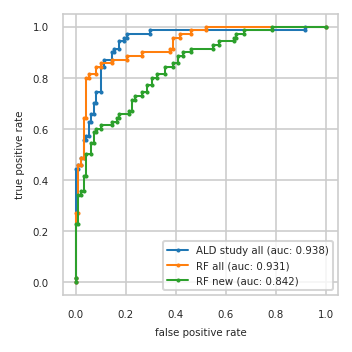

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}